# FINM 359000 Macro Finance
### Problem Set 2
##### Group Members:
- Hongsen (Henry) Fu
- Huayu (Alaia) Zhu
- Mange (Kevin) He
- Yuxuan (Ryan) Bai

##### Import Libraries 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
#from func import * 
import seaborn as sns 
from datetime import datetime
import quandl 
import requests
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import kpss, adfuller
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import statsmodels.api as sm

##### Helper Functions

In [5]:
############# Data Fetching #############
# API 
myAPIkey = 'VPTMgg7k44QB9_2PCKWD'
quandl.ApiConfig.api_key = myAPIkey # for Nasdaq 
api_key = 'cf4f0867024084f82351267f25f9d1c6' # for FRED 


#get stock/ ETF data 
def get_stock_data(name, start, end): 
    raw_data = quandl.get_table('QUOTEMEDIA/PRICES', ticker = name, date = {'gte':start, 'lte':end}) 
    df = raw_data.sort_values(by = 'date')
    df.set_index('date', inplace = True)
    df  =  df.loc[:,['adj_close']]
    return df

# get bond data 
def fetch_data_from_FRED(api_key, series_id, file_type, start_date):
    '''
    This function will fetch the bond data given the api key, series id, file type, and start date
    '''

    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type={file_type}&observation_start={start_date}"

    # Make the API request
    response = requests.get(url)

    if response.status_code == 200:
        # Extract data if the request is successful
        data_raw = response.json()
        observations = data_raw['observations']

        # Convert the data into a list of dictionaries (date and value pairs)
        data = [{'date': entry['date'], 'value': entry['value']} for entry in observations]

        # Create a DataFrame and clean the data
        data_df = pd.DataFrame(data)
        data_df['date'] = pd.to_datetime(data_df['date'])
        data_df['value'] = pd.to_numeric(data_df['value'], errors='coerce')  # Convert values to numeric, making non-numeric into NaN
        data_df = data_df.dropna()  # Remove rows with NaN values

        return data_df
    else:
        print('Failed to retrieve data:', response.status_code)
        return pd.DataFrame()
    
def get_bond_data(name, start): 
    df = fetch_data_from_FRED(api_key, series_id = name, file_type = 'json'
                              , start_date = start).set_index('date')
    return df 

########## Data Processing ############
def yield_to_price(df, region, coupon_freq = 2):
    '''
    This function will calculate the price of the bond given the yield

    Parameters:
    df (pd.DataFrame): DataFrame containing the bond yields in a column named 'value'.
    region (str): Region of the bond ('US' or 'EU').
    coupon_freq (int): Frequency of coupon payments per year (default is 2).

    Returns:
    pd.DataFrame: DataFrame containing the bond yield, price, modified duration, convexity, coupon income, and total return.
    '''
    # compute the duration and convexity for price approximation
    # assume each bond is priced at par, so the coupon is equal to the yield
    def row_operation(row):
        face_value = 100
        total_periods = coupon_freq * 10
        coupon = row['value'] / coupon_freq
        y = row['value']/100
        #mod_d = sum([coupon*(-i/coupon_freq)*np.exp(y*(-i/coupon_freq)) for i in range(1, total_periods + 1)])
        mod_d = total_periods/(1+y/2)
        conv = sum([coupon*(i/coupon_freq)**2*np.exp(y*(-i/coupon_freq)) for i in range(1, total_periods + 1)])
        return mod_d, conv

    df[['mod_d', 'conv']] = df.apply(lambda row:row_operation(row), axis=1, result_type='expand')
    df['delta_y'] = df['value'].diff() / 100

    bond_price = [100.0]
    for i in range(1, len(df)):
        new_price = bond_price[-1] + (df['delta_y'].iloc[i] * df['mod_d'].iloc[i-1] + 1/2 * df['delta_y'].iloc[i]**2 * df['conv'].iloc[i-1]) * bond_price[-1]
        bond_price.append(new_price)

    df['price'] = bond_price

    if coupon_freq == 2:
        sample_interval = '6M'
    else:
        sample_interval = '3M'
    mean_coupon = df[['value']].resample(sample_interval).mean()
    mean_coupon.columns = ['coupon_income']

    merged_df = df.join(mean_coupon, how='left')
    merged_df['coupon_income'] = merged_df['coupon_income'].fillna(0).cumsum()
    merged_df['total'] = merged_df['coupon_income'] + merged_df['price']
    return merged_df[['value', 'price', 'mod_d', 'conv','coupon_income', 'total']]

def calculate_weekly_return(df): 
    data = df.copy()
    data['Weekly Return'] = ((data['price'] - data['price'].shift(5)) / data['price'].shift(5)) 
    weekly_data = data.loc[:,['Weekly Return']]
    weekly_data.dropna(inplace=True)
    return weekly_data

############### Plotting ################
def plot_rolling_corr(rolling_corr,constant_corr):
    plt.figure(figsize=(12,6))
    rolling_corr.plot()
    plt.title('Rolling Correlation between SPY and Bond')
    plt.axhline(constant_corr, color='black', lw=1, ls='--')
    plt.xlim(pd.to_datetime(rolling_corr.index.min()), pd.to_datetime(rolling_corr.index.max()))
    max_corr = rolling_corr.idxmax()
    min_corr = rolling_corr.idxmin()
    plt.scatter(max_corr, rolling_corr[max_corr], color='blue', s=50, label='Max Correlation', zorder=5)
    plt.scatter(min_corr, rolling_corr[min_corr], color='orange', s=50, label='Min Correlation', zorder=5)

    plt.show()
    

############# Risk Parity Strategy ################
def risk_parity_weights(volatility1, volatility2, correlation):
    # Calculate the inverse of the Marginal Risk Contributions 
    mrc1 = volatility1 * (volatility1 + correlation * volatility2)
    mrc2 = volatility2 * (volatility2 + correlation * volatility1)
    
    inv_mrc1 = 1 / mrc1
    inv_mrc2 = 1 / mrc2
    
    # Normalize the inverse MRCs to sum to 1 to get the portfolio weights
    weight1 = inv_mrc1 / (inv_mrc1 + inv_mrc2)
    weight2 = inv_mrc2 / (inv_mrc1 + inv_mrc2)
    
    return weight1, weight2

def equal_risk_parity(vol, cov): 
    if not vol.index.equals(cov.index): 
        raise ValueError("Index of vol and cov must be the same")
    n = len(vol)
    weight = pd.DataFrame(index = vol.index, columns = ['weight stock', 'weight bond'])

    for i in range(n):
        weight.iloc[i] = risk_parity_weights(vol.iloc[i,0], vol.iloc[i,1], cov.iloc[i,0])
    return weight


## Part 1. Financial cycles

### 1. What is the market pricing to occur to the Federal Funds rate by end June 2025? Be explicit about the numerical level it is priced to be at by end June 2025 and what this implies about the number of interest rate cuts

### 2. What does history suggest about how investors may want to be invested in macro assets over the next year as a result? Justify your answer quantitatively and specific about what asset classes have typically benefited in these environments, which have not, and what fraction of the time this has been true.

### 3. Do you think your answer to (2) makes sense to extrapolate into how investors should behave right now? Why or why not?

## Part 2. Macro regimes

### 4. Choose two different macro variable data series you can get monthly data on that you think matter for macro asset prices. Choose series that have data available since at least 1995 (you may look back further and will learn more in what follows if you do). Why do you think they matter for macro asset prices, and how? (Be explicit, e.g., “when X happens to variable Y, I would expect asset price Z to go in direction Q”.)

### 5. Define macro regimes since 1995 using these data series. Characterize the regimes and be explicit about dates.

### 6. Quantitatively characterize macro asset performance (equity, government bonds, commodities, credit) during the regimes you specify. What generalizations and conclusions can you make about asset performance during different macro regimes, as you have defined them? Why do you think these generalizations make sense or don’t make sense?

### 7. Do you think you should use the same risk metrics during each macro regime to characterize risk? Why or why not? If you should be considering different metrics, what are they and when should you consider them?

## Part 3. Risk Parity 

##### Data Fetching & Preprocessing 

In [6]:
# Set the date range we want to analyze 
start = '2000-01-01'
end = datetime.now().strftime('%Y-%m-%d')

In [7]:
# Get the data
df_spy = get_stock_data('SPY', start, end).rename(columns={'adj_close':'price'})
df_bond = get_bond_data('DGS10', start)
df_bond = yield_to_price(df_bond, 'US').loc[:,['price']] # Convert yield to price

In [8]:
# Get the weekly return data 
df_spy_ret = calculate_weekly_return(df_spy)
df_bond_ret = calculate_weekly_return(df_bond)

### 8. Observing Correlation 

#### a. From HW 1 you should already have total returns series for US stocks and bonds since 2000. Using weekly returns, estimate the full sample equity-bond return correlation from 2000 to 2019 (inclusive).

Here, we utilized SPY as the proxy for US stocks instead of the commonly used SP500 (SPX), as it is a tradable ETF. This choice facilitates the construction of our portfolio and strategy in subsequent questions. The bonds selected are US 10-year bonds from HW1. Subsequently, we computed the weekly returns, factoring in business dates and holidays, and derived the full sample equity-bond return correlation spanning from 2000 to 2019. The correlation between SPY (representing US stocks) and US 10-year bonds (representing US bonds) is notably modest, approximately 0.3439. While they exhibit movements in the same direction, suggesting potential similar reactions to certain macro events, the correlation remains relatively low.

In [10]:
df_ret_2000_2019 = pd.concat([df_spy_ret, df_bond_ret], axis=1,).loc['2000':'2019']
df_ret_2000_2019.columns = ['SPY', 'Bond']

In [11]:
df_ret_2000_2019.corr()

,SPY,Bond
SPY,1.000000,0.343921
Bond,0.343921,1.000000


- Plot of correlation between SPY and Bond:

<Axes: >

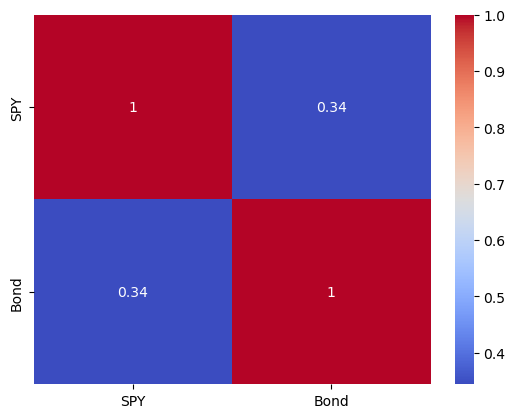

In [12]:
sns.heatmap(df_ret_2000_2019.corr(), annot=True, cmap='coolwarm')

#### b.Now estimate the rolling 1-year equity-bond return correlation over the same sample. What do you notice?

The rolling 1-year correlation between equity (SPY) and bond returns from 2000 to 2019 shows not just a similar mean to the overall sample correlation, but also a high standard deviation, highlighting substantial fluctuations over time. These fluctuations range from a minimum of -0.6727 (2006-05-10) to a maximum of 0.8936 (2010-07-14). The visual pattern in the plot indicates a cyclical behavior in correlation, with periods of rising and falling every few years. However, the cycles do not have a fixed time range, reducing the predicting power. 

For investors employing a risk parity strategy or generally employing a diversification strategy, understanding these correlation dynamics is crucial. Risk parity strategy involves allocating portfolio weights inversely proportional to asset risk, aiming for equal risk contribution from all assets. Given the volatile nature of equity-bond correlations, the expected risk contribution from these assets can change significantly, affecting the portfolio balance. During periods of rising correlation, bonds may offer less diversification benefit against equities, potentially increasing portfolio risk if not rebalanced accordingly. Conversely, periods of negative or low correlation enhance the effectiveness of bonds in providing a hedge against equity risk. Thus, continuous monitoring and dynamic adjustment of asset weights are essential for maintaining the intended risk parity across the portfolio. This approach not only helps in achieving a more stable risk profile but also in navigating through different macroeconomic conditions that might influence asset correlations.

In [13]:
df_rolling_corr = df_ret_2000_2019.rolling(52).corr().unstack().loc[:,'SPY'].dropna()
#display(df_rolling_corr.head(5))

In [14]:
df_rolling_corr.loc[:,['Bond']].describe()

,Bond
count,3299.000000
mean,0.320287
std,0.341046
min,-0.672699
25%,0.078054
50%,0.404819
75%,0.602753
max,0.893569


In [15]:
print(f"Maximum correlation date: {df_rolling_corr.loc[:, ['Bond']].idxmax()}")
print(f"Minimum correlation date: {df_rolling_corr.loc[:, ['Bond']].idxmin()}")


Maximum correlation date: Bond   2010-07-14
dtype: datetime64[ns]
Minimum correlation date: Bond   2006-05-10
dtype: datetime64[ns]


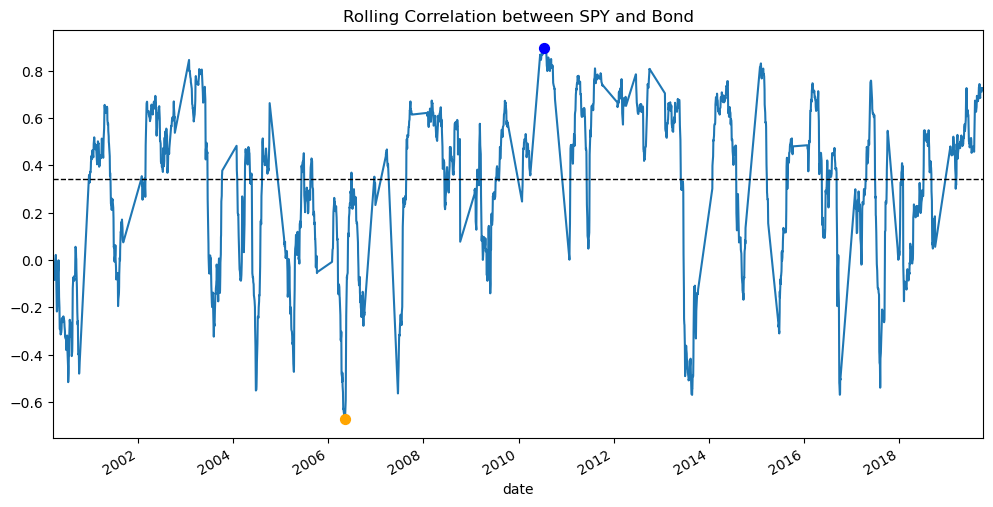

In [16]:
plot_rolling_corr(df_rolling_corr['Bond'],0.34)

### 9. Historical performance


#### a. Suppose you manage a risk parity fund where you allocate the same risk budget to US stocks and to bonds, using as your measure of risk the 1-year trailing return volatility. No leverage, buying on margin or shorting are allowed. What would be the allocation to stocks and bonds, on average, over the life of the fund from 2000 to 2019. Plot how this allocation changes over time.


The risk parity strategy setup logic: 

We know that from portfolio class, risk of the portfolio is calculated by $\sigma_p^2 = \Sigma^n_{i=1}\Sigma_{j=1}^n w_i w_j \sigma_{i,j} = w_1^2 \sigma_1^2 +  w_2^2 \sigma_2^2 + 2w_1w_2 \sigma_{i,j}$.

We then consider the marginal risk contribution, the contribution to total risk from each asset, adjusted for how assets interact through correlation. We adjust the weights and ensure that each asset contributes equally to the portfolio. 

After we constructed our strategy, we decide to adjust the weight every week beginning from Dec 29, 2000 to Dec 27, 2019. The average weight of the stock (SPY) is 0.556174, and the average weight of the bond(US 10 year) is 0.443826. We can see over the 2000-2019 time period, we slightly put more emphasize on SPY, but the weight of those two are quite balanced if looking at mean. However, if we take a closer look of the plot, we can see that the change of weight is quite frequent and volatile. 

In [17]:
df_rolling_vol = df_ret_2000_2019.rolling(52).std().dropna() #calculate 1year trailing return vol 

- Plot of the rolling volatility: 

<Axes: xlabel='date'>

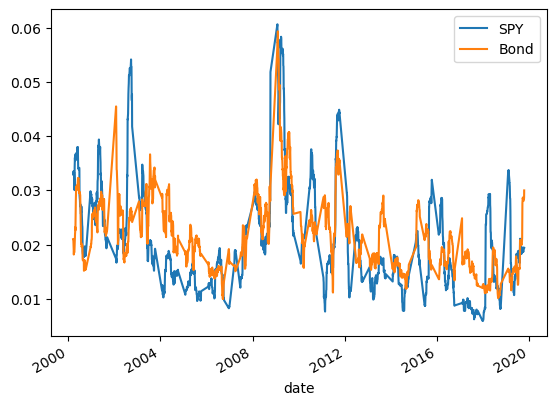

In [18]:
df_rolling_vol.plot()

In [19]:
weight_rp = equal_risk_parity(df_rolling_vol,df_rolling_corr)

In [20]:
weight_rp.mean()

weight stock    0.556174
weight bond     0.443826
dtype: object

- Plot of the weight allocation: 

<Axes: xlabel='date'>

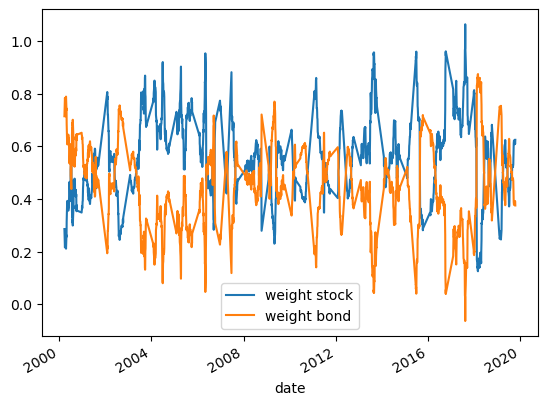

In [21]:
weight_rp.plot()

#### b. What would the average risk of the fund be from 2000 to 2019? How does this change over time? What amount is due to equity and what amount due to bonds?


The average risk of the fund from 2000 to 2019 is roughly 0.442619. It increases and decreases cyclically over time. Since, we used the equal risk parity strategy before, the risk contribution should equally separated to equity and bond. 

In [22]:
def calculate_portfolio_risk(row):
    bond_vol = row['Bond']
    spy_vol = row['SPY']
    corr = row['Correlation']
    weight_bond = row['weight bond']
    weight_spy = row['weight stock']
    
    #portfolio_variance = (weight_bond * bond_vol)**2 + (weight_spy * spy_vol)**2 + 2 * weight_bond * weight_spy * corr
    portfolio_variance=(weight_bond * bond_vol)**2 + (weight_spy * spy_vol)**2 + 2 * weight_bond * weight_spy * corr * bond_vol * spy_vol
    return np.sqrt(portfolio_variance)

df_rolling_corr = df_rolling_corr.rename(columns={'Bond': 'Correlation'})
portfolio_risk = pd.concat([df_rolling_vol, df_rolling_corr[['Correlation']], weight_rp], axis=1)
portfolio_risk['portfolio risk'] = portfolio_risk.apply(calculate_portfolio_risk, axis=1)
pr = portfolio_risk[['portfolio risk']]

- mean of portfolio risk: 

In [23]:
pr.describe()

,portfolio risk
count,3299.000000
mean,0.016411
std,0.006748
min,0.005404
25%,0.011551
50%,0.015054
75%,0.020020
max,0.046972


- plot of portfolio risk over time 

<Axes: xlabel='date'>

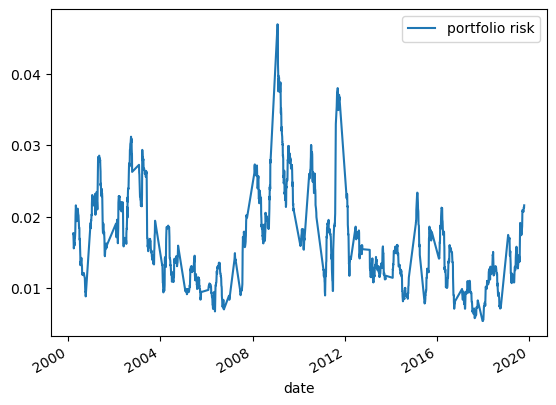

In [24]:
pr.plot()

#### c. Why do you think risk parity is a strategy that is followed, particularly in this case as it relates to stock and bonds?


From the analysis of rolling volatilities and portfolio risk statistics, it is evident that the individual asset classes of bonds and stocks exhibit higher mean volatilities compared to the aggregated portfolio risk. This observation underscores the effectiveness of the risk parity strategy in managing and reducing overall portfolio risk. Particularly, in times of heightened volatility for one asset class, risk parity plays a crucial role in mitigating the impact on the entire portfolio. The data indicates that both the maximum and minimum volatilities for the portfolio are consistently lower than those for individual asset classes, which illustrates the strategy’s capability in stabilizing return fluctuations over time.

The plotted time series further demonstrates how the portfolio risk remains more stable and less prone to extreme fluctuations compared to individual asset volatilities. This stability is paramount in environments where predictability of asset class performance is low. By focusing on risk allocation rather than solely on expected returns, risk parity strategies aim to construct more resilient portfolios that can maintain steady performance across various market conditions.

The observed volatilities of stocks and bonds sometimes peak synchronously, indicating similar reactions to macroeconomic events, while at other times, they do not align, likely reflecting differing sensitivities to various macroeconomic variables. This divergence in reaction underscores the benefit of a risk parity approach, as it allows for a balanced response to shifts in economic conditions, reducing overall exposure to systemic risks and enhancing portfolio robustness.



In [25]:
pd.concat([df_rolling_vol, pr], axis=1).describe()


,SPY,Bond,portfolio risk
count,3299.000000,3299.000000,3299.000000
mean,0.020318,0.021697,0.016411
std,0.009938,0.006981,0.006748
min,0.005907,0.009951,0.005404
25%,0.013164,0.016307,0.011551
50%,0.017914,0.020549,0.015054
75%,0.025516,0.026113,0.020020
max,0.060627,0.059330,0.046972


<Axes: xlabel='date'>

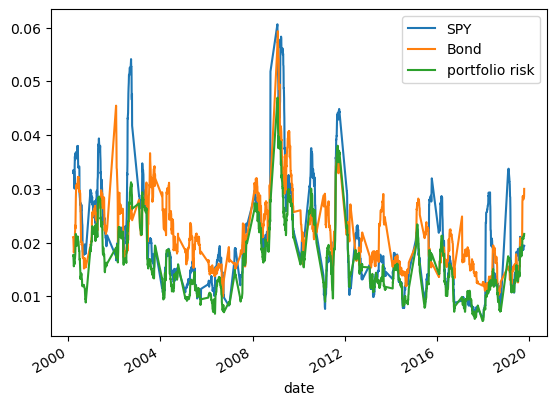

In [26]:
pd.concat([df_rolling_vol, pr], axis=1).plot()

### 10. 2021 to the present


#### a. From 2021 to the present (2022 in particular), what happened to a fund’s performance if the fund followed the risk parity strategy we have thus far outlined?


After 2022, the allocation to stocks significantly surpassed the allocation to bonds, suggesting increased volatility in the bond market relative to stocks. A closer examination of the line plot reveals that post-2022, bond volatility sharply exceeded that of stocks. Consequently, during this period, the portfolio's risk approached the lower volatility levels of stocks, indicating a divergence from previous strategies where bonds offered a stabilizing effect.

This shift suggests that the risk parity strategy was less effective post-2023 compared to earlier periods. Analyzing the returns, we observe that the SPY (stock) returns were notably lower than those of bonds. This period highlights a critical challenge for the risk parity strategy: although it succeeded in reducing exposure to the heightened volatility of bonds by increasing stock allocation, it did not capitalize on higher returns from the less volatile but underperforming stock component.

Thus, while the strategy effectively adjusted for increased bond volatility by reallocating to stocks, it failed to enhance overall portfolio returns significantly. This outcome underscores the limitations of risk parity in scenarios where the less volatile asset class underperforms, thus not contributing positively to the portfolio's risk-return profile as anticipated.

In [27]:
df_ret_2021_2024 = pd.concat([df_spy_ret, df_bond_ret], axis=1,).loc['2021':'2024'].dropna()
df_ret_2021_2024.columns = ['SPY', 'Bond']
df_rolling_corr_fut = df_ret_2021_2024.rolling(52).corr().unstack().loc[:,'SPY'].dropna()
df_rolling_vol_fut = df_ret_2021_2024.rolling(52).std().dropna()

In [28]:
df_weight_fut = equal_risk_parity(df_rolling_vol_fut,df_rolling_corr_fut)

- plot of weight allocation over time: 

<Axes: xlabel='date'>

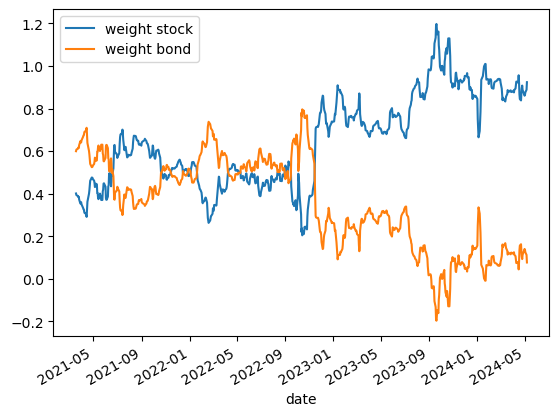

In [29]:
df_weight_fut.plot()

- sharpe ratio analysis: 

In [30]:
def calculate_portfolio_return(row):
    weight_bond = row['weight bond']
    weight_spy = row['weight stock']
    ret_bond = row['Bond return']
    ret_spy = row['SPY return']
    
    portfolio_return = weight_bond * ret_bond + weight_spy * ret_spy 
    return portfolio_return

In [31]:
df_rolling_corr_fut = df_rolling_corr_fut.rename(columns={'Bond': 'Correlation'})
df_ret_2021_2024 = df_ret_2021_2024.rename(columns = {'Bond': 'Bond return', 'SPY':'SPY return'})
portfolio_analysis = pd.concat([df_rolling_vol_fut, df_rolling_corr_fut[['Correlation']], df_weight_fut,df_ret_2021_2024], axis=1).dropna()
portfolio_analysis['portfolio risk'] = portfolio_analysis.apply(calculate_portfolio_risk, axis=1)
portfolio_analysis['portfolio return'] = portfolio_analysis.apply(calculate_portfolio_return, axis =1)
portfolio_analysis = portfolio_analysis.dropna() 
sr_overall = (portfolio_analysis['portfolio return'].mean() * 52)/(portfolio_analysis['portfolio risk'].mean()*np.sqrt(52))
ret_2022 = portfolio_analysis.loc['2022-01-01':'2022-12-31','portfolio return'].mean() * 52
vol_2022 = portfolio_analysis.loc['2022-01-01':'2022-12-31','portfolio risk'].mean() * np.sqrt(52)
sr_2022 = ret_2022/vol_2022
print(f'Sharpe Ratio over 2021-2024: {sr_overall}')
print(f'Sharpe Ratio over 2022: {sr_2022}')

Sharpe Ratio over 2021-2024: 1.726772834863734
Sharpe Ratio over 2022: 1.587955957515046


In [32]:
sr_bond = portfolio_analysis['Bond return'].mean()* np.sqrt(52)/ portfolio_analysis['Bond'].mean() # Bond here represents the bond volatility 
sr_stock =portfolio_analysis['SPY return'].mean()* np.sqrt(52)/ portfolio_analysis['SPY'].mean() 
sr_bond_2022 = portfolio_analysis.loc['2022-01-01':'2022-12-31','Bond return'].mean() * np.sqrt(52)/ portfolio_analysis.loc['2022-01-01':'2022-12-31','Bond'].mean()
sr_stock_2022 = portfolio_analysis.loc['2022-01-01':'2022-12-31','SPY return'].mean()* np.sqrt(52)/ portfolio_analysis.loc['2022-01-01':'2022-12-31','SPY'].mean() 

In [33]:
print(f'Sharpe Ratio Bond: {sr_bond}')
print(f'Sharpe Ratio Stock: {sr_stock}')
print(f'Sharpe Ratio Bond 2022: {sr_bond_2022}')
print(f'Sharpe Ratio Stock 2022: {sr_stock_2022}')

Sharpe Ratio Bond: 1.3332260405829872
Sharpe Ratio Stock: 0.7514033044892281
Sharpe Ratio Bond 2022: 2.558195173552333
Sharpe Ratio Stock 2022: -0.8311508985474358


- risk analysis: 

In [34]:
portfolio_analysis[['SPY', 'Bond', 'portfolio risk']].describe()

,SPY,Bond,portfolio risk
count,785.000000,785.000000,785.000000
mean,0.020905,0.025406,0.015155
std,0.008418,0.007522,0.004652
min,0.009093,0.010994,0.005583
25%,0.013641,0.018425,0.011328
50%,0.019125,0.025828,0.015446
75%,0.027525,0.030812,0.018428
max,0.041044,0.041337,0.025720


<Axes: xlabel='date'>

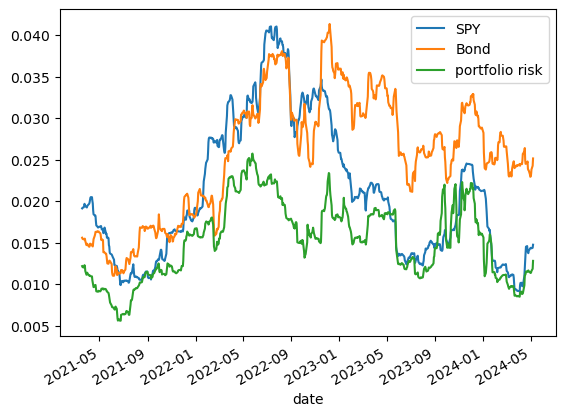

In [35]:
portfolio_analysis[['SPY', 'Bond', 'portfolio risk']].plot()

- return analysis 

In [36]:
portfolio_analysis[['SPY return', 'Bond return', 'portfolio return']].describe()

,SPY return,Bond return,portfolio return
count,785.000000,785.000000,785.000000
mean,0.002178,0.004697,0.003629
std,0.022946,0.027847,0.016385
min,-0.100712,-0.084988,-0.055862
25%,-0.009535,-0.012507,-0.005354
50%,0.003517,0.004227,0.003691
75%,0.015858,0.022828,0.014536
max,0.068958,0.108152,0.051676


#### b. Why did this happen? Both explain and justify your answer quantitatively. How does it relate to the equity-bond return correlation from 2021 to the present?

From the analysis of the financial data from 2021 to the present, two key phenomena emerge that significantly influenced the risk parity strategy's effectiveness:

1. Lower Mean Returns for Stocks: During this period, stocks (SPY) exhibited lower mean returns compared to bonds. This underperformance in stocks suggests a diminished contribution to the portfolio’s overall growth, impacting the risk parity strategy’s ability to leverage equity investments for higher returns.
2. Higher Mean Volatility for Bonds: Simultaneously, bonds experienced significantly higher mean volatility than stocks. This increased volatility in bonds is atypical, as bonds are generally considered more stable investments compared to stocks. The higher volatility in bonds necessitated a strategic shift in asset allocation to mitigate risk, leading to increased weight in the relatively more stable stocks.

The correlation coefficient between SPY and bonds during this period was −0.2550, indicating a mild inverse relationship. This negative correlation suggests that when stocks were underperforming (i.e., lower returns), bonds did not necessarily perform inversely proportional to expectations, which is typically hoped for in a diversification strategy.

The rolling correlation data further indicates that the negative correlation between SPY and bonds persisted longer than in previous periods. This prolonged negative correlation implies that the protective hedging effect of bonds when stocks decline was less effective.

The enduring negative correlation coupled with high volatility in bonds complicates the risk parity strategy. Traditionally, risk parity aims to allocate risk equally among various asset classes based on their volatility. However, with bonds becoming more volatile and less negatively correlated with underperforming stocks, the strategy's usual mechanism of balancing risk through diversification and hedging becomes less efficient. Therefore, the risk parity strategy had to increase allocations to stocks, despite their lower returns, to manage the unexpected higher risk from bonds. The benefit of diversification was undermined by the simultaneous poor performance and reduced negative correlation, leading to challenges in achieving a balanced risk-return profile for the portfolio.

In [37]:
df_ret_2021_2024.corr()

,SPY return,Bond return
SPY return,1.00000,-0.25682
Bond return,-0.25682,1.00000


<Axes: xlabel='date'>

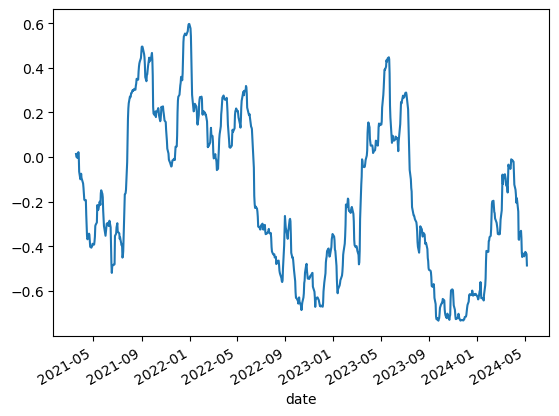

In [38]:
df_rolling_corr_fut['Correlation'].plot()

#### c. What implications do you think this should have for risk parity funds and risk management of these?

1. Funds may need to consider a more dynamic assessment of asset behaviors and not strictly adhere to traditional asset role assignments in their strategies.
2. The prolonged negative correlation between stocks and bonds, diverging from expected inverse movements, emphasizes the importance of enhanced monitoring of correlations. Risk parity funds should integrate advanced analytical tools that can detect and respond to changes in correlation in real-time or near-real-time, enabling quicker strategy adjustments.
3. Expanding beyond traditional stocks and bonds to include other asset classes such as commodities, real estate, or emerging market equities could provide additional layers of diversification. This diversification can help mitigate risks when traditional assets behave outside their typical historical patterns.

